Copyright 2015-2025 Universidad Complutense de Madrid (UCM)

This file contains code adapted from Numina https://github.com/guaix-ucm/numina.

It was developed by N. Cardiel for students of the Astrophysics Master (UCM).

This is an adapted version for lectures at ULS (Chile).

* License:
SPDX-License-Identifier: GPL-3.0+

* Modified by:
C. Cabello (UCM; Spain), 
L. Costantin (CAB; Spain)

## Atmospheric extinction

### Imports

In [1]:
'''
:Settings:
conda activate uls_2025

:History:
23 Mar 25:  version 1.0
'''

import numpy as np
import teareduce as tea
import astropy.units as u
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from pathlib import Path
from tqdm.notebook import tqdm
from astropy.table import QTable
from astropy.io import fits, ascii

tea.avoid_astropy_warnings(True)

__version__ = "1.0"
__author__  = "Cristina Cabello (UCM, Spain) and Luca Costantin (CAB, Spain)"


### Read files

In [2]:
galaxy_ID        = 'NGC2366'
specphot_star_ID = 'HR3454'

## MODIFY THE FOLLOWING

abs_path = f'/home/diegosuzaku/NGC2366Workshop'

dir_calibration = Path(f'{abs_path}/calibration/spectroscopy')



### Atmospheric extinction curve

Spectroscopic exposures must be corrected for atmospheric extinction. This depends on the air mass at the instant of observation. This information is stored in the *keyword* `AIRMASS` of the FITS headers.

The correction depends on the wavelength. We are going to use the approximate expression given in the paper
[The Night Sky at the Calar Alto Observatory](https://ui.adsabs.harvard.edu/abs/2007PASP..119.1186S/abstract) by Sánchez et al. (2007), in which the absorption coefficient can be expressed as

\begin{equation}
A_\lambda \simeq 0.0935 \left(\frac{\lambda}{5450}\right)^{-4} + (0.8 \kappa_V - 0.0935) \left(\frac{\lambda}{5450}\right)^{-0.8},
\end{equation}
where $\kappa_V$ is the absorption coefficient in the $V$ band. Consulting the [CAVEX website](http://www.caha.es/CAVEX/cavex.php) (observatory extinction monitor) for the dates close to the observations, it is seen that a value of $\kappa_V \simeq 0.15;{\rm mag}/{\rm airmass}$ seems reasonable. This value is not very different from that tabulated in Sanchez et al. (2007) for this coefficient on winter nights.

In [3]:
def atmospheric_extinction_CAHA(wavelength, kappa_v=0.15):
    
    if not wavelength.unit.is_equivalent(u.Angstrom):
        raise ValueError(f'Unexpected unit for wavelength: {wavelength.unit}')
    wavelength0 = 5450 * u.Angstrom
    a_lambda = 0.0935*(wavelength.to(u.Angstrom)/wavelength0)**(-4) \
            + (0.8 * kappa_v - 0.0935) \
            * (wavelength.to(u.Angstrom)/wavelength0)**(-0.8)
    
    return a_lambda.value

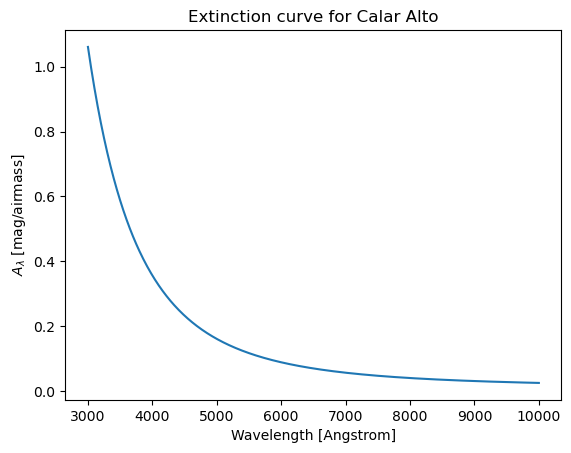

In [4]:
wavelength = np.arange(3000, 10001, 10) * u.Angstrom
a_lambda = atmospheric_extinction_CAHA(wavelength)

fig, ax = plt.subplots()
ax.plot(wavelength, a_lambda, '-')
ax.set_xlabel('Wavelength [Angstrom]')
ax.set_ylabel(r'$A_\lambda$ [mag/airmass]')
ax.set_title('Extinction curve for Calar Alto')

plt.show()

The above curve indicates that the atmospheric extinction is more pronounced in the blue part than in the red part. This means that we have to compensate for this effect by multiplying the signal obtained at each wavelength by a factor that we will calculate as

\begin{equation}
f_{\rm atm.corr.}(\lambda; {\rm airmass}) = 10^{0.4 \times {\rm airmass} \times A_\lambda}
\end{equation}

### Spectro-photometric star

In [5]:
table_star = ascii.read(dir_calibration / f'{specphot_star_ID}_1d_spec.ecsv')

flux       = table_star['flux']
wavelength = table_star['wavelength']

header  = fits.getheader(dir_calibration / 't_science_star.fits')
airmass = header['AIRMASS']


We compute the function to correct for atmospheric extinction 

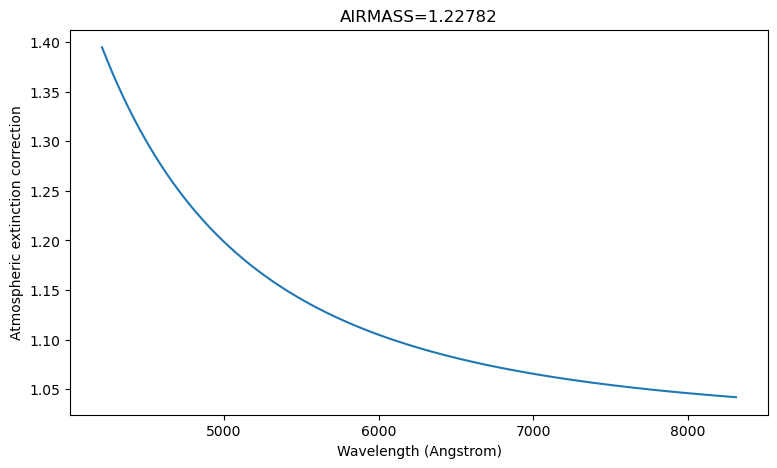

In [6]:
fextinction = 10**(0.4*airmass*atmospheric_extinction_CAHA(wavelength))

fig, ax = plt.subplots(figsize=(9, 5))
ax.plot(wavelength.to(u.Angstrom), fextinction)
ax.set_xlabel('Wavelength (Angstrom)')
ax.set_ylabel('Atmospheric extinction correction')
ax.set_title(f'AIRMASS={airmass}')
plt.show()


We correct the inital data:

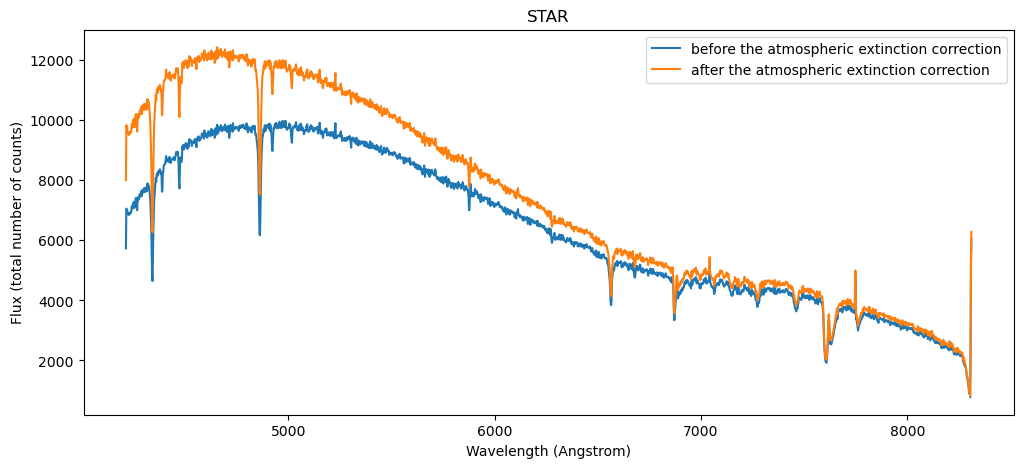

In [7]:
data_corrected  = flux * fextinction
spectrum_before = flux
spectrum_after  = data_corrected

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(wavelength.to(u.Angstrom), spectrum_before, label='before the atmospheric extinction correction')
ax.plot(wavelength.to(u.Angstrom), spectrum_after, label='after the atmospheric extinction correction')
ax.set_xlabel('Wavelength (Angstrom)')
ax.set_ylabel('Flux (total number of counts)')
ax.set_title(f'STAR')
ax.legend()

plt.show()

In [8]:
## saving 1D spectrum
table_spectrum = QTable()

table_spectrum['wavelength'] = wavelength.to(u.Angstrom)
table_spectrum['flux'] = spectrum_after * u.adu

table_spectrum['wavelength'].info.format = '.2f'
table_spectrum['flux'].info.format = '.2f'

table_spectrum.write(dir_calibration / f'{specphot_star_ID}_1d_spec_atmcorr.ecsv', overwrite=True)


### Galaxy

In [9]:
table_target = ascii.read(dir_calibration / f'{galaxy_ID}_1d_spec.ecsv')

flux       = table_target['flux']
wavelength = table_target['wavelength']

header1 = fits.getheader(dir_calibration / 't_science_galaxy_1.fits')
header2 = fits.getheader(dir_calibration / 't_science_galaxy_2.fits')
header3 = fits.getheader(dir_calibration / 't_science_galaxy_3.fits')

airmass1 = header1['AIRMASS']
airmass2 = header2['AIRMASS']
airmass3 = header3['AIRMASS']

airmass = np.mean([airmass1,airmass2,airmass3])


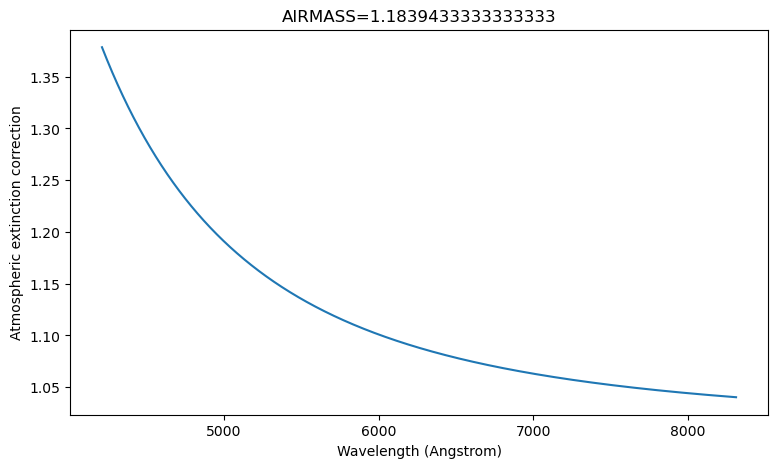

In [10]:
fextinction = 10**(0.4*airmass*atmospheric_extinction_CAHA(wavelength))

fig, ax = plt.subplots(figsize=(9, 5))
ax.plot(wavelength.to(u.Angstrom), fextinction)
ax.set_xlabel('Wavelength (Angstrom)')
ax.set_ylabel('Atmospheric extinction correction')
ax.set_title(f'AIRMASS={airmass}')
plt.show()

[]

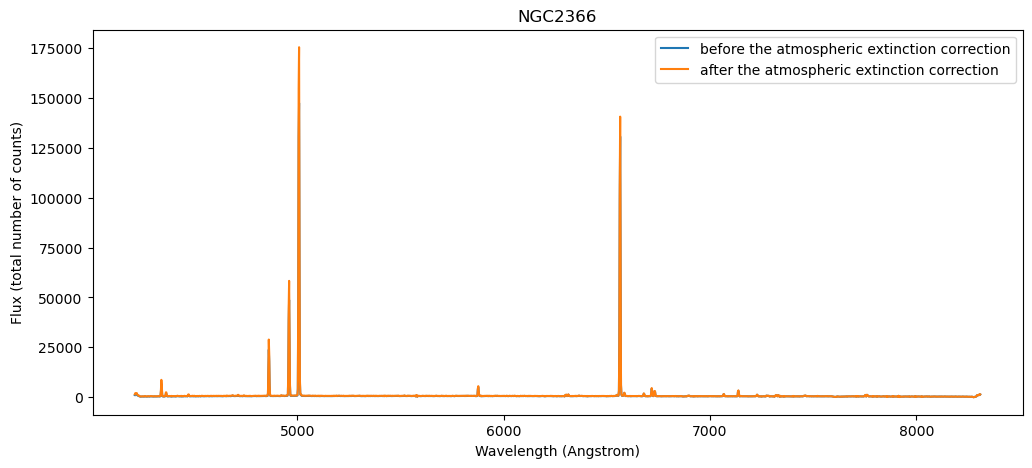

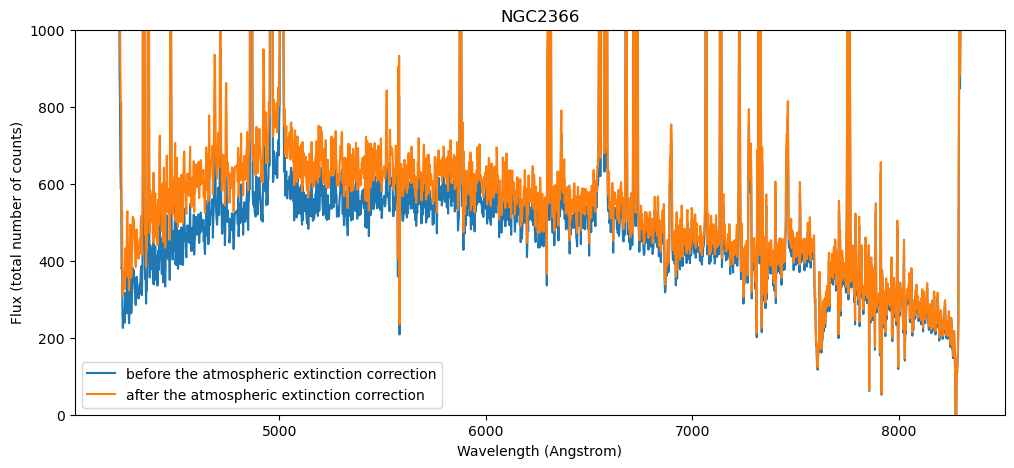

In [11]:
data_corrected  = flux * fextinction
spectrum_before = flux
spectrum_after  = data_corrected

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(wavelength.to(u.Angstrom), spectrum_before, label='before the atmospheric extinction correction')
ax.plot(wavelength.to(u.Angstrom), spectrum_after, label='after the atmospheric extinction correction')
ax.set_xlabel('Wavelength (Angstrom)')
ax.set_ylabel('Flux (total number of counts)')
ax.set_title(f'{galaxy_ID}')
ax.legend()

plt.plot()

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(wavelength.to(u.Angstrom), spectrum_before, label='before the atmospheric extinction correction')
ax.plot(wavelength.to(u.Angstrom), spectrum_after, label='after the atmospheric extinction correction')
ax.set_xlabel('Wavelength (Angstrom)')
ax.set_ylabel('Flux (total number of counts)')
ax.set_title(f'{galaxy_ID}')
ax.set_ylim(0,1000)
ax.legend()

plt.plot()

In [12]:
## saving 1D spectrum
table_spectrum = QTable()

table_spectrum['wavelength'] = wavelength.to(u.Angstrom)
table_spectrum['flux'] = spectrum_after * u.adu

table_spectrum['wavelength'].info.format = '.2f'
table_spectrum['flux'].info.format = '.2f'

table_spectrum.write(dir_calibration / f'{galaxy_ID}_1d_spec_atmcorr.ecsv', overwrite=True)
